# Figure 13: Processed volumes

In [2]:
%run import-modules-grid

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

!jupyter --version

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

import pickle

#ORIGDATA=True # read in original pyko data and make pickle file with extracted data
ORIGDATA=False # read in pickled extracted ata


Platform:  Darwin Kernel Version 24.1.0: Thu Oct 10 21:00:32 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6030
python version:  3.11.10
matplotlib version:  3.9.2
hvplot version:  0.11.0
numpy version:  2.1.2
pandas version:  2.2.3
pickle version:  4.0
yaml version:  6.0.2
pint version:  0.24.3
pyko version:  v0.8.3-dev-2024-05-12
print eos_table version:  v1.1.5b

Number of CPUs in the system: 12


Selected Jupyter core packages...
IPython          : 8.28.0
ipykernel        : 6.29.5
ipywidgets       : 8.1.5
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server   : 2.14.2
jupyterlab       : 4.2.5
nbclient         : 0.10.0
nbconvert        : 7.16.4
nbformat         : 5.10.4
notebook         : not installed
qtconsole        : not installed
traitlets        : 5.14.3


In [3]:
rplumeinitarr = np.asarray([25.e3]) # m
rnebinitarr = np.asarray([250.e6,50.e6,10.e6]) #m
tsavearr = np.asarray([10.,5.,2.]) #s
pinitarr = np.asarray([80.e9,40.e9,20.e9,15.e9])
velinitarr = np.asarray([0.]) # m/s


In [4]:

all_label = []
all_tmax = []
all_pmax = []
all_cvol = []
all_rstall = []
all_plumeIM = []
all_nebIM = []

if ORIGDATA:
#    fin='./vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg100.yml'
#    fout='./vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg100-'
    fin='./pyko-data/water-dig/vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg1.yml'
    fout='./pyko-data/water-dig/vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg1-'

    ftype='YAML'
    verbose=True
    userdtstart=0.
    usertstepscale=0.
    binoutput=True
    debug=False
    initarr=False
    #run = RunClass(fin=fin,fout=fout,ftype=ftype)    # initialize run parameters class
    #
    # read in the run template
    #readinput_yaml(run,verbose=0)
    #print(run.ieos[0].path)
    #hugarr = np.loadtxt(run.ieos[0].path+'NEW-SESAME-HUG-E.TXT',skiprows=3,delimiter=',')
    #print('Hugoniot file size = ',hugarr.shape)
    # vary starting parameters
    for ipp in range(len(pinitarr)):
        for irp in range(len(rplumeinitarr)):
            for ivel in range(len(velinitarr)):            
                fileid = 'P'+str(np.round(pinitarr[ipp]/1.e9))+'-R'+str(np.round(rplumeinitarr[irp]/1.e3))+'-V'+str(np.round(velinitarr[ivel]/1.e2)/10)
                #fileid='cth5-ring'
                outputfilename = fout+fileid+'.dat'
                label = 'dg1-'+fileid[0:-7]
                print("#outputfilename='"+outputfilename+"'")
                %run load-calc.ipynb
                
                jall = np.unique(pko['j'])
                pmaxarr = np.zeros(len(jall))
                tmaxarr = np.zeros(len(jall))
                rinitarr = np.zeros(len(jall))
                volinitarr = np.zeros(len(jall))
                cvolinitarr = np.zeros(len(jall))
                cvolplotarr = np.zeros(len(jall))
                
                imatarr = np.zeros(len(jall))
                for ij in range(0,len(jall)):
                    pmaxarr[ij] = max(pko['pres'][pko['j']==jall[ij]])
                    tmaxarr[ij] = max(pko['temp'][pko['j']==jall[ij]])
                    rinitarr[ij] = pko['pos'][(pko['j']==jall[ij]) & (pko['time']==0.)]
                    imatarr[ij] = pko['material'][(pko['j']==jall[ij]) & (pko['time']==0.)]
                
                imat2 = np.where(imatarr == 2)[0] # nebula within rstall
                for ij in range(0,len(imat2)):
                   volinitarr[imat2[ij]] =  np.power(rinitarr[imat2[ij]]+(rinitarr[imat2[ij]+1]-rinitarr[imat2[ij]])/2.,3)-np.power(rinitarr[imat2[ij]]-(rinitarr[imat2[ij]]-rinitarr[imat2[ij]-1])/2.,3)
                   cvolinitarr[imat2[ij]] =  np.sum(volinitarr[imat2[0:ij]])
                volrstall = np.power(rstall/1.e6,3)
                cvolplotarr[imat2] = 1-cvolinitarr[imat2]/volrstall

                
                all_label.append(label)
                all_tmax.append(tmaxarr[imat2])
                all_pmax.append(pmaxarr[imat2])
                all_cvol.append(cvolplotarr[imat2])
                all_rstall.append(rstall/1.e6)

                jmaxmat1=max(pko['j'][pko['mat']==1])
                plupko = pko[['pres', 'up','rho','temp','j','time','pos']][pko['j']==jmaxmat1].copy()
                nebpko = pko[['pres', 'up','rho','temp','j','time','pos']][pko['j']==jmaxmat1+2].copy()
                plupko.to_csv(outputfilename[0:-4]+'-IM.csv')

                all_plumeIM.append(plupko)
                all_nebIM.append(nebpko)
                
##                %run plot-save-three.ipynb
##                %run plot-save.ipynb
##                stop

In [5]:
#rplumeinitarr = np.asarray([25.e3]) # m

all_label_100 = []
all_tmax_100 = []
all_pmax_100 = []
all_cvol_100 = []
all_rstall_100 = []
all_plumeIM_100 = []
all_nebIM_100 = []

if ORIGDATA:
#    fin='./vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg100.yml'
#    fout='./vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg100-'
#    fin='./data/vp-h2o-tempgridlong-dg100.yml'
#    fout='./data/vp-h2o-tempgridlong-dg100-'
    fin='./pyko-data/water-dig/vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg100.yml'
    fout='./pyko-data/water-dig/vp-h2o-dig-tempgridlong-p1Pa-small2/vp-h2o-tempgridlong-dg100-'

    ftype='YAML'
    verbose=True
    userdtstart=0.
    usertstepscale=0.
    binoutput=True
    debug=False
    initarr=False
    #run = RunClass(fin=fin,fout=fout,ftype=ftype)    # initialize run parameters class
    #
    # read in the run template
    #readinput_yaml(run,verbose=0)
    #print(run.ieos[0].path)
    #hugarr = np.loadtxt(run.ieos[0].path+'NEW-SESAME-HUG-E.TXT',skiprows=3,delimiter=',')
    #print('Hugoniot file size = ',hugarr.shape)
    # vary starting parameters
    for ipp in range(len(pinitarr)):
        for irp in range(len(rplumeinitarr)):
            for ivel in range(len(velinitarr)):            
                fileid = 'P'+str(np.round(pinitarr[ipp]/1.e9))+'-R'+str(np.round(rplumeinitarr[irp]/1.e3))+'-V'+str(np.round(velinitarr[ivel]/1.e2)/10)
                #fileid='cth5-ring'
                outputfilename = fout+fileid+'.dat'
                label = 'dg100-'+fileid[0:-7]
                print("#outputfilename='"+outputfilename+"'")
                %run load-calc.ipynb
                
                jall = np.unique(pko['j'])
                pmaxarr = np.zeros(len(jall))
                tmaxarr = np.zeros(len(jall))
                rinitarr = np.zeros(len(jall))
                volinitarr = np.zeros(len(jall))
                cvolinitarr = np.zeros(len(jall))
                cvolplotarr = np.zeros(len(jall))
                
                imatarr = np.zeros(len(jall))
                for ij in range(0,len(jall)):
                    pmaxarr[ij] = max(pko['pres'][pko['j']==jall[ij]])
                    tmaxarr[ij] = max(pko['temp'][pko['j']==jall[ij]])
                    rinitarr[ij] = pko['pos'][(pko['j']==jall[ij]) & (pko['time']==0.)]
                    imatarr[ij] = pko['material'][(pko['j']==jall[ij]) & (pko['time']==0.)]
                
                imat2 = np.where(imatarr == 2)[0] # nebula within rstall
                for ij in range(0,len(imat2)):
                   volinitarr[imat2[ij]] =  np.power(rinitarr[imat2[ij]]+(rinitarr[imat2[ij]+1]-rinitarr[imat2[ij]])/2.,3)-np.power(rinitarr[imat2[ij]]-(rinitarr[imat2[ij]]-rinitarr[imat2[ij]-1])/2.,3)
                   cvolinitarr[imat2[ij]] =  np.sum(volinitarr[imat2[0:ij]])
                volrstall = np.power(rstall/1.e6,3)
                cvolplotarr[imat2] = 1-cvolinitarr[imat2]/volrstall

                all_label_100.append(label)
                all_tmax_100.append(tmaxarr[imat2])
                all_pmax_100.append(pmaxarr[imat2])
                all_cvol_100.append(cvolplotarr[imat2])
                all_rstall_100.append(rstall/1.e6)


                jmaxmat1=max(pko['j'][pko['mat']==1])
                plupko = pko[['pres', 'up','rho','temp','j','time','pos']][pko['j']==jmaxmat1].copy()
                nebpko = pko[['pres', 'up','rho','temp','j','time','pos']][pko['j']==jmaxmat1+2].copy()
                plupko.to_csv(outputfilename[0:-4]+'-IM.csv')

                all_plumeIM_100.append(plupko)
                all_nebIM_100.append(nebpko)

                ##                %run plot-save-three.ipynb
##                %run plot-save.ipynb
##                stop

In [6]:

if ORIGDATA:
    with open('./data/volfrac.pkl','wb') as f:
        pickle.dump([all_label_100,all_tmax_100,all_pmax_100,all_cvol_100,all_rstall_100,all_plumeIM_100,all_nebIM_100,all_label,all_tmax,all_pmax,all_cvol,all_rstall,all_plumeIM,all_nebIM],f)  
    print('saving volfrac.pkl')


In [7]:
if not ORIGDATA:
    with open('./data/volfrac.pkl','rb') as f:
        [all_label_100,all_tmax_100,all_pmax_100,all_cvol_100,all_rstall_100,all_plumeIM_100,all_nebIM_100,all_label,all_tmax,all_pmax,all_cvol,all_rstall,all_plumeIM,all_nebIM]=pickle.load(f)


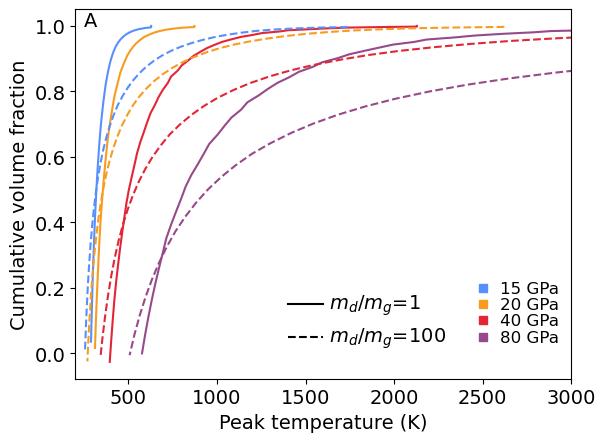

In [46]:
plt.rcParams.update({'font.size': 14})

#pcol = ["#1845fb", "#ff5e02", "#c91f16", "#c849a9", "#adad7d", "#86c8dd", "#578dff", "#656364"]
# ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]
pcol1 = ["#5790fc", "#f89c20", "#e42536", "#964a8b"]
pcol = pcol1[::-1]

for ii in range(0,len(all_cvol)):          
    plt.plot(all_tmax[ii],all_cvol[ii],color=pcol[ii],label=all_label[ii][0:-6]+' GPa')

for ii in range(0,len(all_cvol_100)):          
    plt.plot(all_tmax_100[ii],all_cvol_100[ii],'--',color=pcol[ii],label=all_label_100[ii][0:-6]+' GPa')

# add shock pressure legend
ineb=0
yval=(np.arange(6)+1)/20.
for ipp in range(len(all_cvol)):
    plt.plot(2500,yval[ipp],'s',color=pcol[ipp])#,label='water-dusty gas '+str(plumedig.pinitarr[ipp]/1.e9)+' GPa')
    plt.text(2600,yval[ipp]-.015,all_label[ipp][5:-6]+' GPa',fontsize=12)
plt.text(1600,yval[0]-.015,' $m_d$/$m_g$=100')
plt.text(1600,yval[2]-.015,' $m_d$/$m_g$=1')
plt.plot([1400,1600],[yval[0],yval[0]],'k--')
plt.plot([1400,1600],[yval[2],yval[2]],'k-')

plt.xlim(200,3000)
#plt.legend(bbox_to_anchor= (1.01, .51),fontsize=12)
plt.xlabel('Peak temperature (K)')
plt.ylabel('Cumulative volume fraction')
plt.text(250,1,'A')
plt.savefig('./plots/Fig13-vol-shock-a.pdf')



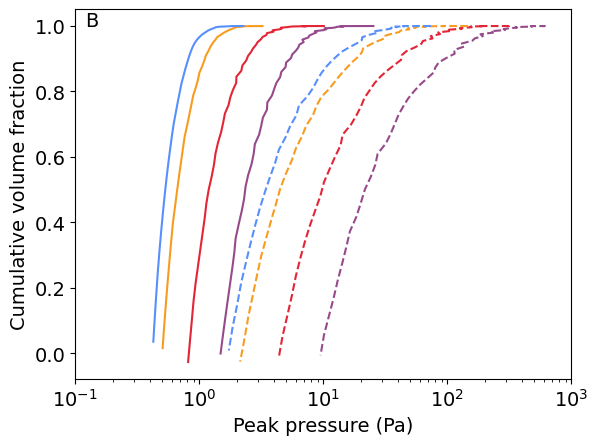

In [47]:
plt.rcParams.update({'font.size': 14})
for ii in range(0,len(all_cvol)):          
    plt.plot(all_pmax[ii],all_cvol[ii],color=pcol[ii],label=all_label[ii])
for ii in range(0,len(all_cvol_100)):          
    plt.plot(all_pmax_100[ii],all_cvol_100[ii],'--',color=pcol[ii],label=all_label_100[ii])

#plt.yrange(0,1000)
#plt.legend()
plt.xlim(0.1,1000)
plt.xscale('log')
plt.xlabel('Peak pressure (Pa)')
plt.ylabel('Cumulative volume fraction')
plt.text(.12,1.,'B')
plt.savefig('./plots/Fig13-vol-shock-b.pdf')